# Imports

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image 

# Lecture 1 / Ex. 1

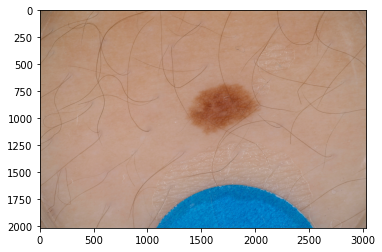

In [3]:
# Load an image and display it

im = plt.imread('fyp2021p3/data/example_image/ISIC_0001769.jpg')
plt.imshow(im)

In [4]:
#A color image is a array with 3 dimensions (x, y, R-G-B color channels) of integers

print(im.shape)
print(im.dtype)

#Other packages might wrap the image in a different class - you are allowed to use those if you want


(2016, 3024, 3)
uint8


[  0 120 196]


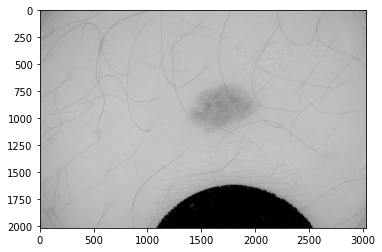

In [5]:
# Get a single RGB value from the blue circle (marker used by dermatologist)
print(im[2000,2000,:])

# Show only the red channel
plt.imshow(im[:,:,0], cmap='gray')



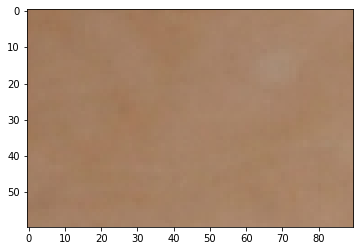

In [6]:
# Display only a part of the image

im_part = im[60:120,130:220,:]
plt.imshow(im_part)

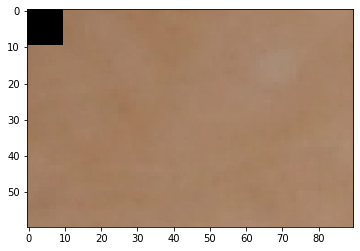

In [7]:
# Modify the image by setting some pixels to black

im_copy = im_part.copy()


im_copy[0:10,0:10,:] = np.tile(0, [10, 10, 3])
plt.imshow(im_copy)

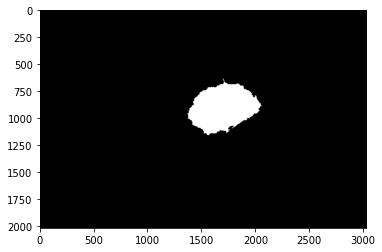

In [8]:
mask=plt.imread('fyp2021p3/data/example_segmentation/ISIC_0001769_segmentation.png')
plt.imshow(mask, cmap='gray')

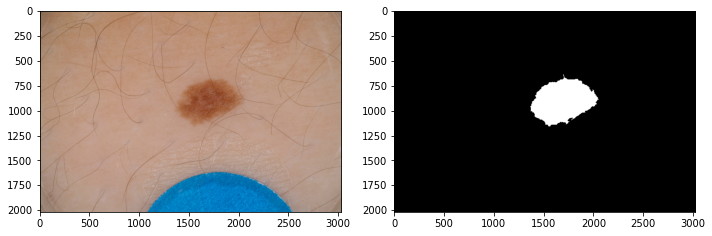

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
axes[0].imshow(im)
axes[1].imshow(mask, cmap='gray')
fig.tight_layout()

(3024, 2016)


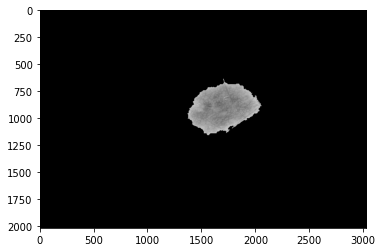

In [12]:
# Load images as Image objects  
img1 = Image.open('fyp2021p3/data/example_image/ISIC_0001769.jpg') 
img2 = Image.open('fyp2021p3/data/example_segmentation/ISIC_0001769_segmentation.png') 
  
# Overlay - more options such as transparency should be available here  
img2.paste(img1, (0,0), mask = img2) 
  
# Display 
img2.show()  # This doesn't actually display an image in Google Colab :(
plt.imshow(img2, cmap='gray')


# Note that this is a single channel image
print(img2.size)

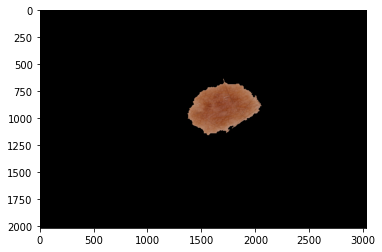

In [13]:
# Alternative: replace the non-lesion pixels

img1 = im.copy()
img1[mask==0] = 0
  
# Display 
plt.imshow(img1)

# You can use any package you prefer, but beware you might need to convert between formats

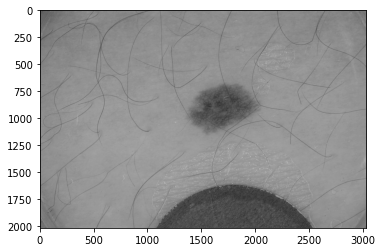

In [14]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

img1 = plt.imread('fyp2021p3/data/example_image/ISIC_0001769.jpg')
gray = rgb2gray(img1)

plt.imshow(gray, cmap='gray')

(array([[0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([ 30.8587 ,  53.11868,  75.37866,  97.63864, 119.89862, 142.1586 ,
        164.41858, 186.67856, 208.93854, 231.19852, 253.4585 ]),
 <a list of 3024 BarContainer objects>)

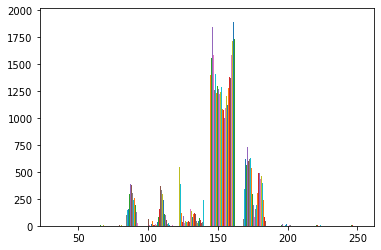

In [15]:
plt.hist(gray)

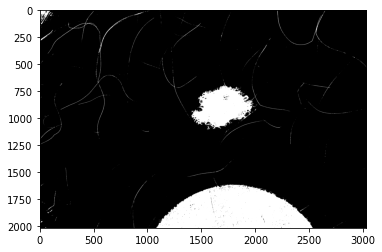

In [16]:
img2 = gray < 120
plt.imshow(img2, cmap='gray')